Self-Training半监督学习系统 - 染色质碎裂检测

主要功能：
- 使用ResNet18提取图像特征
- 结合CNV特征进行多模态学习
- 实现Self-Training半监督学习
- 对比基线模型与半监督模型性能

# 1. 导入库和全局配置

In [1]:
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, f1_score, roc_auc_score
from sklearn.semi_supervised import SelfTrainingClassifier
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import joblib
import warnings
warnings.filterwarnings('ignore')

# 全局配置
BASE_DIR = "/Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model"
OUTPUT_DIR = os.path.join(BASE_DIR, "semi_supervised_learning")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 2. 设备和模型初始化

初始化深度学习设备和预训练模型
- 自动检测并选择最优计算设备（MPS/CPU）
- 加载预训练ResNet18模型用于图像特征提取
- 设置图像预处理管道

In [2]:
# 设置计算设备
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"使用设备: {device}")

# 初始化ResNet18预训练模型
weights = models.ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights).to(device)
model = torch.nn.Sequential(*list(model.children())[:-1])  # 移除分类层
model.eval()

# 图像预处理管道
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# CNV特征标准化器
cnv_scaler = StandardScaler()

使用设备: mps


# 3. 特征提取函数

定义图像特征提取和数据准备的核心函数
- extract_image_features_batch: 批量提取图像特征，提高效率
- prepare_data: 数据预处理，包括路径验证和特征提取

In [11]:
def extract_image_features_batch(image_paths, batch_size=32):
    """
    批量提取图像特征
    
    参数:
        image_paths: 图像路径列表
        batch_size: 批处理大小，默认32
    
    返回:
        features: 提取的图像特征矩阵 (n_samples, 512)
    """
    features_list = []
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]
        batch_images = []
        
        for path in batch_paths:
            try:
                img = Image.open(path).convert("RGB")
                batch_images.append(preprocess(img))
            except Exception as e:
                print(f"处理图像 {path} 时出错: {e}")
                batch_images.append(torch.zeros(3, 224, 224))
        
        batch_tensor = torch.stack(batch_images).to(device)
        with torch.no_grad():
            batch_features = model(batch_tensor)
            batch_features = batch_features.squeeze(-1).squeeze(-1)
        features_list.append(batch_features.cpu().numpy())
        
        if i % (batch_size * 10) == 0:
            print(f"已处理 {i+len(batch_paths)}/{len(image_paths)} 张图像")
    
    return np.vstack(features_list)

def prepare_data(df, image_dir, is_labeled=True):
    """
    准备训练数据
    
    参数:
        df: 数据DataFrame
        image_dir: 图像目录路径
        is_labeled: 是否为有标签数据
    
    返回:
        df_valid: 有效数据DataFrame
        valid_paths: 有效图像路径列表
        cnv_features: CNV特征矩阵
        labels: 标签数组（仅当is_labeled=True时返回）
    """
    # 确保CNV特征是数值型
    for col in ['cn_2', 'cn_3', 'cn_segments']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # 构建完整图像路径
    image_paths = [os.path.join(image_dir, img) for img in df['image_path']]
    
    # 检查图像是否存在
    valid_paths = []
    valid_indices = []
    for i, path in enumerate(image_paths):
        if os.path.exists(path):
            valid_paths.append(path)
            valid_indices.append(i)
        else:
            print(f"警告: 图像 {path} 不存在")
    
    # 筛选有效数据
    df_valid = df.iloc[valid_indices].reset_index(drop=True)
    cnv_features = df_valid[['cn_2', 'cn_3', 'cn_segments']].values
    
    if is_labeled:
        labels = df_valid['label'].values
        return df_valid, valid_paths, cnv_features, labels
    else:
        return df_valid, valid_paths, cnv_features


# 4. 数据加载模块

数据加载和预处理模块
- load_labeled_data: 加载有标签数据，并分割训练集和验证集
- load_unlabeled_data: 加载未标注数据用于半监督学习

In [4]:

def load_labeled_data():
    """
    加载有标签数据（约3000条）
    
    功能：
    - 加载标注数据和对应的SV图像
    - 分层抽样留出10%的有标签数据作为独立验证集
    - 返回训练集和验证集的数据
    
    数据路径：
    - 数据文件: semi_supervised_learning/manual_label/merge.tsv
    - 图像目录: semi_supervised_learning/manual_label/graph_dir
    """
    print("="*60)
    print("STEP 1: 数据准备与基线确认")
    print("="*60)
    
    labeled_data_path = os.path.join(BASE_DIR, "semi_supervised_learning/manual_label/merge.tsv")
    labeled_image_dir = os.path.join(BASE_DIR, "semi_supervised_learning/manual_label/graph_dir")
    
    if not os.path.exists(labeled_data_path):
        print(f"错误: 有标签数据文件 {labeled_data_path} 不存在")
        return None, None, None, None, None, None
    
    df_labeled = pd.read_csv(labeled_data_path, sep='\t')
    print(f"有标签数据总数: {len(df_labeled)}")
    print(f"标签分布:\n{df_labeled['label'].value_counts()}")
    
    # 准备数据
    df_valid, image_paths, cnv_features, labels = prepare_data(
        df_labeled, labeled_image_dir, is_labeled=True
    )
    
    # 留出100-300条作为最终验证集
    validation_size = min(300, max(100, int(0.1 * len(df_valid))))
    
    # 分层抽样保留验证集
    train_indices, val_indices = train_test_split(
        range(len(df_valid)), 
        test_size=validation_size, 
        stratify=labels,
        random_state=42
    )
    
    # 分割数据
    train_image_paths = [image_paths[i] for i in train_indices]
    val_image_paths = [image_paths[i] for i in val_indices]
    
    train_cnv = cnv_features[train_indices]
    val_cnv = cnv_features[val_indices]
    
    train_labels = labels[train_indices]
    val_labels = labels[val_indices]
    
    print(f"训练数据: {len(train_labels)} 条")
    print(f"最终验证数据: {len(val_labels)} 条")
    print(f"训练数据标签分布: {np.bincount(train_labels)}")
    print(f"验证数据标签分布: {np.bincount(val_labels)}")
    
    return (train_image_paths, train_cnv, train_labels, 
            val_image_paths, val_cnv, val_labels)

def load_unlabeled_data():
    """
    加载未标注数据（约30k条）
    
    功能：
    - 加载未标注数据和对应的SV图像
    - 用于Self-Training半监督学习
    
    数据路径：
    - 数据文件: semi_supervised_learning/TCGA-test/simulation.remove_manual_label_part.filled.tsv
    - 图像目录: SV_graph.simulated/TCGA_graph
    """
    unlabeled_data_path = os.path.join(BASE_DIR, 
        "semi_supervised_learning/TCGA-test/simulation.remove_manual_label_part.filled.tsv")
    unlabeled_image_dir = os.path.join(BASE_DIR, "SV_graph.simulated/TCGA_graph")
    
    if not os.path.exists(unlabeled_data_path):
        print(f"错误: 未标注数据文件 {unlabeled_data_path} 不存在")
        return None, None, None
    
    df_unlabeled = pd.read_csv(unlabeled_data_path, sep='\t')
    print(f"未标注数据总数: {len(df_unlabeled)}")
    
    # 准备数据
    df_valid, image_paths, cnv_features = prepare_data(
        df_unlabeled, unlabeled_image_dir, is_labeled=False
    )
    
    return df_valid, image_paths, cnv_features
    

# 5. 特征提取

执行特征提取和合并
- 使用ResNet18提取图像特征（512维）
- 标准化CNV特征（3维：cn_2, cn_3, cn_segments）
- 合并多模态特征（总共515维）

In [5]:
print("加载有标签数据...")
labeled_data = load_labeled_data()
if labeled_data[0] is None:
    print("有标签数据加载失败，程序终止")
    exit()

print("\n加载未标注数据...")
unlabeled_data = load_unlabeled_data()

# 解包有标签数据
(train_image_paths, train_cnv, train_labels, 
 val_image_paths, val_cnv, val_labels) = labeled_data

print("\n提取有标签数据特征...")
# 提取训练图像特征
train_image_features = extract_image_features_batch(train_image_paths)

# 提取验证图像特征
val_image_features = extract_image_features_batch(val_image_paths)


加载有标签数据...
STEP 1: 数据准备与基线确认
有标签数据总数: 2898
标签分布:
label
1    2037
0     861
Name: count, dtype: int64
训练数据: 2609 条
最终验证数据: 289 条
训练数据标签分布: [ 775 1834]
验证数据标签分布: [ 86 203]

加载未标注数据...
未标注数据总数: 22237

提取有标签数据特征...
已处理 32/2609 张图像
已处理 352/2609 张图像
已处理 672/2609 张图像
已处理 992/2609 张图像
已处理 1312/2609 张图像
已处理 1632/2609 张图像
已处理 1952/2609 张图像
已处理 2272/2609 张图像
已处理 2592/2609 张图像
已处理 32/289 张图像


# 6. CNV标准化+特征合并

特征标准化和合并
- 对CNV特征进行Z-score标准化
- 合并图像特征和CNV特征
- 保持特征空间的一致性

In [6]:
# 标准化CNV特征
train_cnv_scaled = cnv_scaler.fit_transform(train_cnv)
val_cnv_scaled = cnv_scaler.transform(val_cnv)

# 合并特征
train_features = np.hstack((train_image_features, train_cnv_scaled))
val_features = np.hstack((val_image_features, val_cnv_scaled))

print(f"训练特征形状: {train_features.shape}")
print(f"验证特征形状: {val_features.shape}")

# 处理未标注数据特征
unlabeled_features = None
if unlabeled_data is not None:
    print("\n提取未标注数据特征...")
    df_unlabeled, unlabeled_image_paths, unlabeled_cnv = unlabeled_data
    
    # 提取未标注图像特征
    unlabeled_image_features = extract_image_features_batch(unlabeled_image_paths)
    
    # 标准化CNV特征
    unlabeled_cnv_scaled = cnv_scaler.transform(unlabeled_cnv)
    
    # 合并特征
    unlabeled_features = np.hstack((unlabeled_image_features, unlabeled_cnv_scaled))
    print(f"未标注特征形状: {unlabeled_features.shape}")


训练特征形状: (2609, 515)
验证特征形状: (289, 515)

提取未标注数据特征...
已处理 32/22237 张图像
已处理 352/22237 张图像
已处理 672/22237 张图像
已处理 992/22237 张图像
已处理 1312/22237 张图像
已处理 1632/22237 张图像
已处理 1952/22237 张图像
已处理 2272/22237 张图像
已处理 2592/22237 张图像
已处理 2912/22237 张图像
已处理 3232/22237 张图像
已处理 3552/22237 张图像
已处理 3872/22237 张图像
已处理 4192/22237 张图像
已处理 4512/22237 张图像
已处理 4832/22237 张图像
已处理 5152/22237 张图像
已处理 5472/22237 张图像
已处理 5792/22237 张图像
已处理 6112/22237 张图像
已处理 6432/22237 张图像
已处理 6752/22237 张图像
已处理 7072/22237 张图像
已处理 7392/22237 张图像
已处理 7712/22237 张图像
已处理 8032/22237 张图像
已处理 8352/22237 张图像
已处理 8672/22237 张图像
已处理 8992/22237 张图像
已处理 9312/22237 张图像
已处理 9632/22237 张图像
已处理 9952/22237 张图像
已处理 10272/22237 张图像
已处理 10592/22237 张图像
已处理 10912/22237 张图像
已处理 11232/22237 张图像
已处理 11552/22237 张图像
已处理 11872/22237 张图像
已处理 12192/22237 张图像
已处理 12512/22237 张图像
已处理 12832/22237 张图像
已处理 13152/22237 张图像
已处理 13472/22237 张图像
已处理 13792/22237 张图像
已处理 14112/22237 张图像
已处理 14432/22237 张图像
已处理 14752/22237 张图像
已处理 15072/22237 张图像
已处理 15392/22237 张图像
已处理 

# 7. 保存处理后的特征


保存特征和数据处理器
- 保存训练和验证特征
- 保存CNV标准化器
- 保存特征维度信息

In [7]:
# 创建处理数据目录
processed_dir = os.path.join(OUTPUT_DIR, 'processed_data')
os.makedirs(processed_dir, exist_ok=True)

# 保存特征和标签
np.save(os.path.join(processed_dir, 'train_features.npy'), train_features)
np.save(os.path.join(processed_dir, 'train_labels.npy'), train_labels)
np.save(os.path.join(processed_dir, 'val_features.npy'), val_features)
np.save(os.path.join(processed_dir, 'val_labels.npy'), val_labels)

if unlabeled_features is not None:
    np.save(os.path.join(processed_dir, 'unlabeled_features.npy'), unlabeled_features)

# 保存数据处理器
joblib.dump(cnv_scaler, os.path.join(processed_dir, 'cnv_scaler.pkl'))

# 保存特征维度信息
feature_dimensions = np.array([train_image_features.shape[1], train_cnv_scaled.shape[1]])
np.save(os.path.join(processed_dir, 'feature_dimensions.npy'), feature_dimensions)

print("特征提取和保存完成")

特征提取和保存完成


## 加载保存的数据

In [2]:
# 加载数据
print(f"\n加载已保存的中间变量...")

# 加载处理后的特征和标签
processed_dir = os.path.join(OUTPUT_DIR, 'processed_data')
train_features = np.load(os.path.join(processed_dir, 'train_features.npy'))
train_labels = np.load(os.path.join(processed_dir, 'train_labels.npy'))
val_features = np.load(os.path.join(processed_dir, 'val_features.npy'))
val_labels = np.load(os.path.join(processed_dir, 'val_labels.npy'))

# 加载未标注特征（如果存在）
unlabeled_features_path = os.path.join(processed_dir, 'unlabeled_features.npy')
if os.path.exists(unlabeled_features_path):
    unlabeled_features = np.load(unlabeled_features_path)
    print(f"未标注特征已加载: {unlabeled_features.shape}")
else:
    unlabeled_features = None
    print("未标注特征文件不存在")

# 加载数据处理器
cnv_scaler = joblib.load(os.path.join(processed_dir, 'cnv_scaler.pkl'))

# 加载特征维度信息
feature_dimensions = np.load(os.path.join(processed_dir, 'feature_dimensions.npy'))

print(f"已加载变量:")
print(f"- train_features: {train_features.shape}")
print(f"- train_labels: {train_labels.shape}") 
print(f"- val_features: {val_features.shape}")
print(f"- val_labels: {val_labels.shape}")
print(f"- feature_dimensions: {feature_dimensions}")
print(f"- cnv_scaler: 已加载")


加载已保存的中间变量...
未标注特征已加载: (22237, 515)
已加载变量:
- train_features: (2609, 515)
- train_labels: (2609,)
- val_features: (289, 515)
- val_labels: (289,)
- feature_dimensions: [512   3]
- cnv_scaler: 已加载


# 8. 监督学习基线模型


建立监督学习基线模型
- 仅使用有标签数据训练LogisticRegression
- 10折交叉验证 + 网格搜索超参数
- 获得基准模型的 ROC_AUC/F1-score

此前的最佳超参数组合（用于减少超参数组合，并在已有组合提升参数的分辨率） 
- PCAWG数据，无扩增 
    - 最佳参数: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}  
    - 交叉验证AUC: 0.9791 [PCAWG_data only]

- PCAWG数据，model_extended_data 中寻找的最佳超参数组合
    - 最佳参数: {'C': 1, 'class_weight': None, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}  
    - 交叉验证AUC: 0.9708 [PCAWG_data with extended data]

该模块在扩增50例假阴性数据的最佳超参数组合：[使用 roc_auc 为评价标准]
- Fitting 10 folds for each of 70 candidates, totalling 700 fits
- 基线模型最佳参数: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
- 基线模型交叉验证ROC_AUC分数: 0.9796

该模块在扩增50例假阴性数据的最佳超参数组合：[使用 f1-score 为评价标准]
- 基线模型最佳参数: {'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
- 基线模型交叉验证F1分数: 0.9589

In [5]:
def establish_baseline(train_features, train_labels):
    """
    建立监督学习基线model
    
    功能：
    - 仅使用有标签数据训练LogisticRegression
    - 10折交叉验证确保结果稳定性，判断标准为 roc_auc/F1 score (根据对应代码进行调整)
    - 网格搜索优化超参数（C, class_weight, penalty）
    """
    print("\n" + "="*60)
    print("建立监督学习基线（仅使用有标签数据）")
    print("="*60)
    
    # 定义监督学习的超参数网格
    param_grid = [
        # l1正则化 (需要用liblinear或saga求解器)
        {
            'penalty': ['l1'],
            'C': [0.01, 0.1, 1, 10],
            'solver': ['liblinear', 'saga'],
            'class_weight': [None, 'balanced']
        },
        # l2正则化 (可以用多种求解器)
        {
            'penalty': ['l2'],
            'C': [0.01, 0.1, 1, 10],
            'solver': ['liblinear', 'saga', 'lbfgs'],
            'class_weight': [None, 'balanced']
        },
        # elasticnet正则化 (只能用saga求解器，需要指定l1_ratio)
        {
            'penalty': ['elasticnet'],
            'C': [0.01, 0.1, 1, 10],
            'solver': ['saga'],
            'l1_ratio': [0.4, 0.5, 0.6],
            'class_weight': [None, 'balanced']
        },
        # 无正则化 (不能用liblinear求解器)
        {
            'penalty': [None],
            'solver': ['newton-cg', 'lbfgs', 'saga'],
            'class_weight': [None, 'balanced']
        }
    ]
    
    # 10折交叉验证
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    # 网格搜索
    grid_search = GridSearchCV(
        LogisticRegression(max_iter=10000, random_state=42),
        param_grid,
        cv=cv,
        scoring='f1', # 选择判断依据 f1/roc_auc
        n_jobs=-1,
        verbose=1
    )
    
    print("开始基线模型网格搜索...")
    grid_search.fit(train_features, train_labels)
    
    baseline_model = grid_search.best_estimator_
    baseline_score = grid_search.best_score_
    
    print(f"基线模型最佳参数: {grid_search.best_params_}")
    print(f"基线模型交叉验证F1分数: {baseline_score:.4f}")
    
    return baseline_model, baseline_score

# 执行基线模型训练
baseline_model, baseline_score = establish_baseline(train_features, train_labels)



建立监督学习基线（仅使用有标签数据）
开始基线模型网格搜索...
Fitting 10 folds for each of 70 candidates, totalling 700 fits
基线模型最佳参数: {'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
基线模型交叉验证F1分数: 0.9589


In [4]:
# 保存基线模型【交叉验证以ROC_AUC为评价标准】的情况下

print(f"\n保存基线模型...")
model_dir = os.path.join(OUTPUT_DIR, 'model')
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, 'baseline_model_roc_auc.pkl')
joblib.dump(baseline_model, model_path)
print(f"模型已保存至: {model_path}")

# 输出重要模型信息
print(f"\n基线模型信息:")
print(f"- 模型类型: LogisticRegression")
print(f"- 交叉验证ROC_AUC分数: {baseline_score:.4f}")
print(f"- 最佳参数: {baseline_model.get_params()}")
print(f"- 训练样本数: {len(train_labels)}")
print(f"- 特征维度: {train_features.shape[1]}")


保存基线模型...
模型已保存至: /Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/semi_supervised_learning/model/baseline_model.pkl

基线模型信息:
- 模型类型: LogisticRegression
- 交叉验证ROC_AUC分数: 0.9796
- 最佳参数: {'C': 1, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
- 训练样本数: 2609
- 特征维度: 515


In [6]:
# 保存基线模型【交叉验证以F1-score为评价标准】

print(f"\n保存基线模型...")
model_dir = os.path.join(OUTPUT_DIR, 'model')
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, 'baseline_model_f1_score.pkl')
joblib.dump(baseline_model, model_path)
print(f"模型已保存至: {model_path}")

# 输出重要模型信息
print(f"\n基线模型信息:")
print(f"- 模型类型: LogisticRegression")
print(f"- 交叉验证F1-score分数: {baseline_score:.4f}")
print(f"- 最佳参数: {baseline_model.get_params()}")
print(f"- 训练样本数: {len(train_labels)}")
print(f"- 特征维度: {train_features.shape[1]}")


保存基线模型...
模型已保存至: /Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/semi_supervised_learning/model/baseline_model_f1_score.pkl

基线模型信息:
- 模型类型: LogisticRegression
- 交叉验证F1-score分数: 0.9589
- 最佳参数: {'C': 1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
- 训练样本数: 2609
- 特征维度: 515


# 9. Self-Training半监督学习


Self-Training半监督学习模块
- 使用SelfTrainingClassifier包装LogisticRegression
- 迭代训练：预测→选择高置信度样本→重新训练
- 使用baseline_model的超参数组合，不再网格搜索
- 最大迭代次数固定为15，threshold设为0.85, 0.90, 0.95三种情况
- 训练三个不同threshold的模型用于后续验证

In [8]:
def self_training_phase(train_features, train_labels, unlabeled_features, baseline_model):
    """
    Self-Training半监督学习阶段
    
    功能：
    - 使用SelfTrainingClassifier包装LogisticRegression
    - 迭代过程：预测未标注数据 → 选择高置信度样本 → 加入训练集 → 重新训练
    - 使用baseline_model的超参数组合，无需网格搜索
    - 最大迭代次数固定为15，threshold设为0.85, 0.90, 0.95三种情况
    - 训练三个不同threshold的模型用于后续验证
    """
    print("\n" + "="*60)
    print("STEP 2: Self-Training半监督学习")
    print("="*60)
    
    # 获取baseline_model的超参数
    baseline_params = baseline_model.get_params()
    print(f"使用baseline_model的超参数: {baseline_params}")
    
    # 准备半监督数据
    # 组合有标签和无标签数据
    if unlabeled_features is not None:
        X_semi = np.vstack([train_features, unlabeled_features])
        y_semi = np.hstack([train_labels, [-1] * len(unlabeled_features)])  # -1表示未标注
    else:
        print("警告: 未找到未标注数据，将仅使用有标签数据进行训练")
        X_semi = train_features
        y_semi = train_labels
    
    print(f"半监督训练数据形状: {X_semi.shape}")
    print(f"其中有标签数据: {len(train_labels)} 条")
    if unlabeled_features is not None:
        print(f"其中未标注数据: {len(unlabeled_features)} 条")
    
    # 定义三个不同的threshold值
    thresholds = [0.85, 0.90, 0.95]
    max_iter = 15
    
    # 存储三个模型的字典
    st_models = {}
    
    print(f"\n使用固定max_iter={max_iter}，训练三个不同threshold的Self-Training模型...")
    
    for threshold in thresholds:
        print(f"\n训练threshold={threshold}的模型...")
        
        # 创建Self-Training分类器，使用baseline_model的超参数
        st_model = SelfTrainingClassifier(
            base_estimator=LogisticRegression(**baseline_params),
            threshold=threshold,
            max_iter=max_iter,
            criterion='threshold',
            verbose=True
        )
        
        # 训练模型
        st_model.fit(X_semi, y_semi)
        
        # 存储模型
        st_models[f'threshold_{threshold}'] = st_model
        
        print(f"threshold={threshold}的模型训练完成")
        print(f"新标注样本数: {len(st_model.labeled_iter_)}")
        
        # 保存模型
        model_dir = os.path.join(OUTPUT_DIR, 'model')
        os.makedirs(model_dir, exist_ok=True)
        model_path = os.path.join(model_dir, f'self_training_model_threshold_{threshold}.pkl')
        joblib.dump(st_model, model_path)
        print(f"模型已保存至: {model_path}")
    
    print(f"\n所有Self-Training模型训练完成")
    print(f"共训练了{len(st_models)}个模型，threshold分别为: {thresholds}")
    
    return st_models

# 执行Self-Training训练
st_models = self_training_phase(train_features, train_labels, unlabeled_features, baseline_model)



STEP 2: Self-Training半监督学习
使用baseline_model的超参数: {'C': 1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
半监督训练数据形状: (24846, 515)
其中有标签数据: 2609 条
其中未标注数据: 22237 条

使用固定max_iter=15，训练三个不同threshold的Self-Training模型...

训练threshold=0.85的模型...
End of iteration 1, added 21259 new labels.
End of iteration 2, added 975 new labels.
threshold=0.85的模型训练完成
新标注样本数: 24846
模型已保存至: /Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/semi_supervised_learning/model/self_training_model_threshold_0.85.pkl

训练threshold=0.9的模型...
End of iteration 1, added 20663 new labels.
End of iteration 2, added 1574 new labels.
threshold=0.9的模型训练完成
新标注样本数: 24846
模型已保存至: /Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/semi_supervised_learning/model/self_training_model_threshold_0.9.pkl

训练threshold=0

# 10. 模型评估和比较

模型性能评估和比较模块
- 在最终验证集上评估基线模型和Self-Training模型
- 生成详细的分类报告和性能指标
- 绘制ROC曲线对比图
- 选择性能更优的模型作为最终模型


STEP 3: 模型评估与比较

=== 基线模型性能 ===
F1: 0.9655, 准确率: 0.9516, AUC: 0.9877

=== Self-Training模型性能 ===
threshold_0.85: F1: 0.9608, 准确率: 0.9446, AUC: 0.9859
  相对基线F1提升: -0.0047
threshold_0.9: F1: 0.9631, 准确率: 0.9481, AUC: 0.9877
  相对基线F1提升: -0.0024
threshold_0.95: F1: 0.9631, 准确率: 0.9481, AUC: 0.9878
  相对基线F1提升: -0.0024

=== 最优模型 ===
最优模型: baseline
最优F1分数: 0.9655


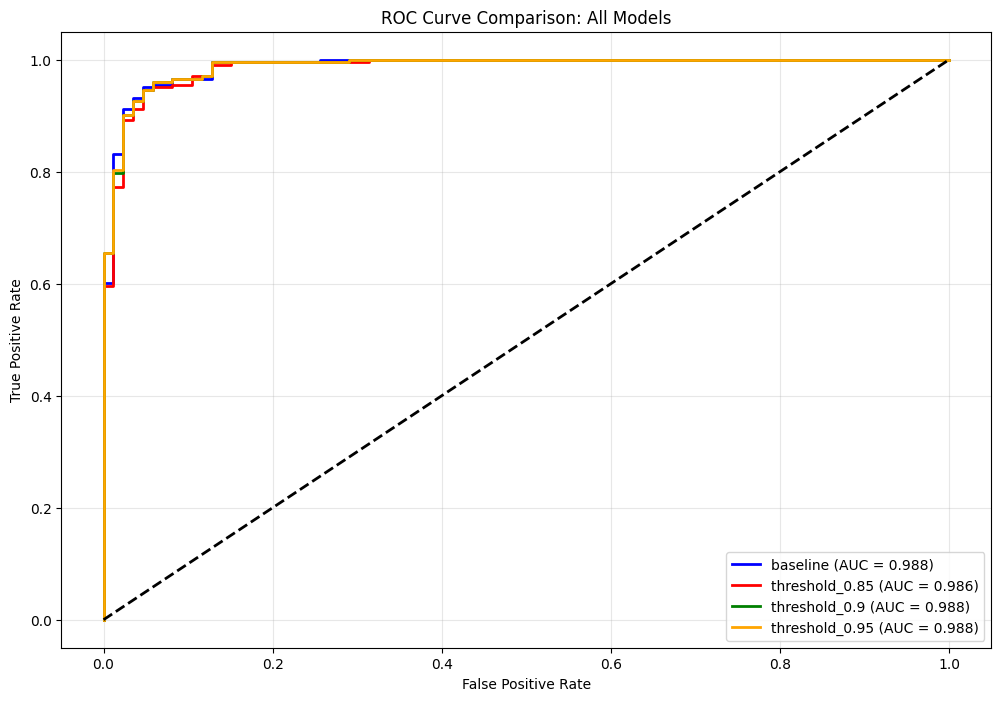

ROC曲线比较图已保存到: /Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/semi_supervised_learning/roc_comparison_all.png

=== 详细分类报告 ===

baseline:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        86
           1       0.97      0.97      0.97       203

    accuracy                           0.95       289
   macro avg       0.94      0.94      0.94       289
weighted avg       0.95      0.95      0.95       289


threshold_0.85:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91        86
           1       0.96      0.97      0.96       203

    accuracy                           0.94       289
   macro avg       0.94      0.93      0.93       289
weighted avg       0.94      0.94      0.94       289


threshold_0.9:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91        86
           1       0.96      0.97      0.96       203

    accuracy

In [9]:

def evaluate_all_models(baseline_model, st_models, val_features, val_labels):
    """
    评估和比较基线模型与所有Self-Training模型
    
    功能：
    - 在独立验证集上评估基线模型和三个Self-Training模型
    - 计算F1分数、准确率、AUC等指标
    - 生成详细的分类报告
    - 返回性能最优的模型
    """
    print("\n" + "="*60)
    print("STEP 3: 模型评估与比较")
    print("="*60)
    
    # 存储所有模型的结果
    results = {}
    
    # 基线模型评估
    baseline_pred = baseline_model.predict(val_features)
    baseline_prob = baseline_model.predict_proba(val_features)[:, 1]
    baseline_f1 = f1_score(val_labels, baseline_pred)
    baseline_acc = accuracy_score(val_labels, baseline_pred)
    baseline_auc = roc_auc_score(val_labels, baseline_prob)
    
    results['baseline'] = {
        'model': baseline_model,
        'predictions': baseline_pred,
        'probabilities': baseline_prob,
        'f1': baseline_f1,
        'accuracy': baseline_acc,
        'auc': baseline_auc
    }
    
    print(f"\n=== 基线模型性能 ===")
    print(f"F1: {baseline_f1:.4f}, 准确率: {baseline_acc:.4f}, AUC: {baseline_auc:.4f}")
    
    # 评估三个Self-Training模型
    print(f"\n=== Self-Training模型性能 ===")
    for model_name, st_model in st_models.items():
        st_pred = st_model.predict(val_features)
        st_prob = st_model.predict_proba(val_features)[:, 1]
        st_f1 = f1_score(val_labels, st_pred)
        st_acc = accuracy_score(val_labels, st_pred)
        st_auc = roc_auc_score(val_labels, st_prob)
        
        results[model_name] = {
            'model': st_model,
            'predictions': st_pred,
            'probabilities': st_prob,
            'f1': st_f1,
            'accuracy': st_acc,
            'auc': st_auc
        }
        
        print(f"{model_name}: F1: {st_f1:.4f}, 准确率: {st_acc:.4f}, AUC: {st_auc:.4f}")
        print(f"  相对基线F1提升: {st_f1 - baseline_f1:+.4f}")
    
    # 找到F1分数最高的模型
    best_model_name = max(results.keys(), key=lambda x: results[x]['f1'])
    best_model = results[best_model_name]['model']
    best_f1 = results[best_model_name]['f1']
    
    print(f"\n=== 最优模型 ===")
    print(f"最优模型: {best_model_name}")
    print(f"最优F1分数: {best_f1:.4f}")
    
    # 绘制ROC曲线比较
    plot_roc_comparison_all(val_labels, results)
    
    # 详细分类报告
    print(f"\n=== 详细分类报告 ===")
    for model_name, result in results.items():
        print(f"\n{model_name}:")
        print(classification_report(val_labels, result['predictions']))
    
    return best_model, best_f1, results

def plot_roc_comparison_all(y_true, results):
    """
    绘制所有模型的ROC曲线比较图
    
    参数:
        y_true: 真实标签
        results: 包含所有模型结果的字典
    """
    plt.figure(figsize=(12, 8))
    
    colors = ['blue', 'red', 'green', 'orange']
    markers = ['o', '^', 's', 'D']
    
    for i, (model_name, result) in enumerate(results.items()):
        fpr, tpr, _ = roc_curve(y_true, result['probabilities'])
        auc_score = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=2, color=colors[i], 
                label=f'{model_name} (AUC = {auc_score:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison: All Models')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    
    # 保存图片
    output_path = os.path.join(OUTPUT_DIR, 'roc_comparison_all.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"ROC曲线比较图已保存到: {output_path}")

# 执行模型评估
best_model, best_score, all_results = evaluate_all_models(baseline_model, st_models, val_features, val_labels)


# 11. 与ShatterSeek的比较



重新获取验证集对应的ShatterSeek结果...
成功获取验证集对应的ShatterSeek结果: (289, 11)

STEP 4: 与ShatterSeek性能比较
ChromShatter (最优模型) 性能：
精确率: 0.9655
召回率: 0.9655
F1分数: 0.9655

ShatterSeek性能：
精确率: 0.9429
召回率: 0.9754
F1分数: 0.9588

=== 性能比较 ===
ChromShatter vs ShatterSeek:
F1分数提升: +0.0067
精确率提升: +0.0227
召回率提升: -0.0099


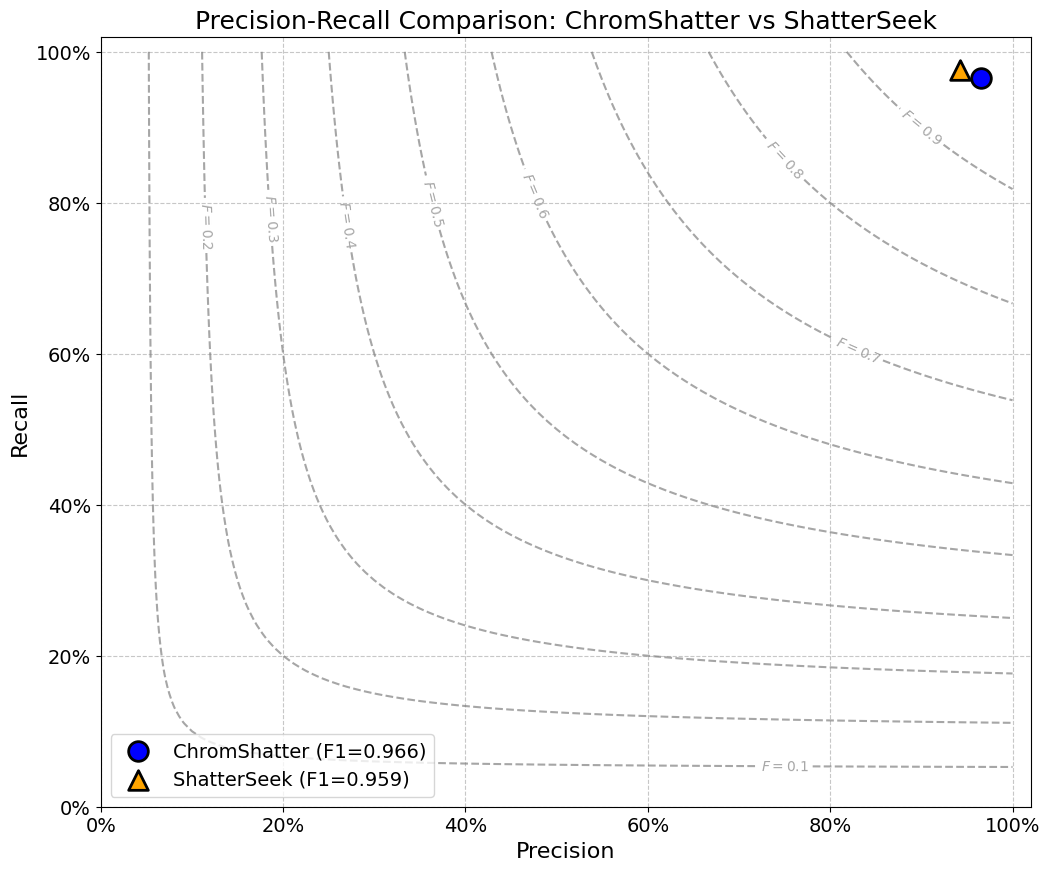

Precision-Recall比较图已保存到: /Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/semi_supervised_learning/precision_recall_comparison.png

详细分类报告

=== ChromShatter (最优模型) 详细分类报告 ===
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        86
           1       0.97      0.97      0.97       203

    accuracy                           0.95       289
   macro avg       0.94      0.94      0.94       289
weighted avg       0.95      0.95      0.95       289


=== ShatterSeek 详细分类报告 ===
              precision    recall  f1-score   support

           0       0.94      0.86      0.90        86
           1       0.94      0.98      0.96       203

    accuracy                           0.94       289
   macro avg       0.94      0.92      0.93       289
weighted avg       0.94      0.94      0.94       289



In [14]:
def compare_with_shatterseek(best_model, val_features, val_labels, val_df):
    """
    与ShatterSeek进行比较
    
    功能：
    - 比较最优模型与ShatterSeek的性能
    - 绘制Precision-Recall图
    - 计算各种性能指标
    
    参数：
        best_model: 最优模型
        val_features: 验证集特征
        val_labels: 验证集标签
        val_df: 验证集DataFrame（包含ShatterSeek结果）
    """
    print("\n" + "="*60)
    print("STEP 4: 与ShatterSeek性能比较")
    print("="*60)
    
    # 获取最优模型的预测结果
    best_pred = best_model.predict(val_features)
    best_prob = best_model.predict_proba(val_features)[:, 1]
    
    # 计算ChromShatter指标
    from sklearn.metrics import precision_score, recall_score
    precision_chromshatter = precision_score(val_labels, best_pred)
    recall_chromshatter = recall_score(val_labels, best_pred)
    f1_chromshatter = f1_score(val_labels, best_pred)
    
    print(f"ChromShatter (最优模型) 性能：")
    print(f"精确率: {precision_chromshatter:.4f}")
    print(f"召回率: {recall_chromshatter:.4f}")
    print(f"F1分数: {f1_chromshatter:.4f}")
    
    # 获取ShatterSeek结果
    shatterseek_pred = val_df['shatterSeek_label'].astype(int).values
    
    # 计算ShatterSeek指标
    precision_shatterseek = precision_score(val_labels, shatterseek_pred)
    recall_shatterseek = recall_score(val_labels, shatterseek_pred)
    f1_shatterseek = f1_score(val_labels, shatterseek_pred)
    
    print(f"\nShatterSeek性能：")
    print(f"精确率: {precision_shatterseek:.4f}")
    print(f"召回率: {recall_shatterseek:.4f}")
    print(f"F1分数: {f1_shatterseek:.4f}")
    
    print(f"\n=== 性能比较 ===")
    print(f"ChromShatter vs ShatterSeek:")
    print(f"F1分数提升: {f1_chromshatter - f1_shatterseek:+.4f}")
    print(f"精确率提升: {precision_chromshatter - precision_shatterseek:+.4f}")
    print(f"召回率提升: {recall_chromshatter - recall_shatterseek:+.4f}")
    
    # 绘制Precision-Recall比较图
    plot_precision_recall_comparison(
        val_labels, 
        best_pred, 
        shatterseek_pred,
        precision_chromshatter, recall_chromshatter, f1_chromshatter,
        precision_shatterseek, recall_shatterseek, f1_shatterseek
    )
    
    # 打印详细的分类报告
    print(f"\n" + "="*60)
    print("详细分类报告")
    print("="*60)
    
    print(f"\n=== ChromShatter (最优模型) 详细分类报告 ===")
    print(classification_report(val_labels, best_pred))
    
    print(f"\n=== ShatterSeek 详细分类报告 ===")
    print(classification_report(val_labels, shatterseek_pred))

def plot_precision_recall_comparison(y_true, chromshatter_pred, shatterseek_pred,
                                   precision_cs, recall_cs, f1_cs,
                                   precision_ss, recall_ss, f1_ss):
    """
    绘制Precision-Recall比较图（包含F1等值线）
    
    参数：
        y_true: 真实标签
        chromshatter_pred: ChromShatter预测结果
        shatterseek_pred: ShatterSeek预测结果
        precision_cs, recall_cs, f1_cs: ChromShatter指标
        precision_ss, recall_ss, f1_ss: ShatterSeek指标
    """
    plt.figure(figsize=(12, 10))
    
    # 绘制F1等值线
    def plot_f1_contours():
        precision_range = np.linspace(0.01, 1, 100)
        recall_range = np.linspace(0.01, 1, 100)
        P, R = np.meshgrid(precision_range, recall_range)
        
        # 计算F1值
        F1 = 2 * P * R / (P + R + 1e-10)
        
        # 绘制F1等值线
        levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        contours = plt.contour(P, R, F1, levels=levels, colors='gray', linestyles='dashed', alpha=0.7)
        
        # 添加等值线标签
        plt.clabel(contours, inline=True, fontsize=10, fmt='$F = %.1f$')
    
    # 绘制F1等值线
    plot_f1_contours()
    
    # 绘制模型点
    # ChromShatter用圆圈表示
    plt.scatter(precision_cs, recall_cs, marker='o', s=200, 
               color='blue', label=f'ChromShatter (F1={f1_cs:.3f})', 
               edgecolors='black', linewidth=2)
    
    # ShatterSeek用三角形表示
    plt.scatter(precision_ss, recall_ss, marker='^', s=200, 
               color='orange', label=f'ShatterSeek (F1={f1_ss:.3f})', 
               edgecolors='black', linewidth=2)
    
    # 设置图表属性
    plt.xlabel('Precision', fontsize=16)
    plt.ylabel('Recall', fontsize=16)
    plt.title('Precision-Recall Comparison: ChromShatter vs ShatterSeek', fontsize=18)
    plt.xlim(0, 1.02)
    plt.ylim(0, 1.02)
    plt.xticks(np.arange(0, 1.1, 0.2), [f"{int(x*100)}%" for x in np.arange(0, 1.1, 0.2)], fontsize=14)
    plt.yticks(np.arange(0, 1.1, 0.2), [f"{int(x*100)}%" for x in np.arange(0, 1.1, 0.2)], fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=14, loc='lower left')
    
    # 保存图表
    output_path = os.path.join(OUTPUT_DIR, 'precision_recall_comparison.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Precision-Recall比较图已保存到: {output_path}")

# 重新获取验证集对应的ShatterSeek结果
def get_validation_shatterseek_results():
    """
    使用相同的随机种子重新分割数据，获取验证集对应的ShatterSeek结果
    """
    print("重新获取验证集对应的ShatterSeek结果...")
    
    # 重新加载原始数据
    labeled_data_path = os.path.join(BASE_DIR, "semi_supervised_learning/manual_label/merge.tsv")
    labeled_image_dir = os.path.join(BASE_DIR, "semi_supervised_learning/manual_label/graph_dir")
    
    df_labeled = pd.read_csv(labeled_data_path, sep='\t')
    
    # 重新执行prepare_data函数
    df_valid, image_paths, cnv_features, labels = prepare_data(
        df_labeled, labeled_image_dir, is_labeled=True
    )
    
    # 使用相同的参数重新分割数据
    validation_size = min(300, max(100, int(0.1 * len(df_valid))))
    
    # 使用相同的随机种子进行分割
    train_indices, val_indices = train_test_split(
        range(len(df_valid)), 
        test_size=validation_size, 
        stratify=labels,
        random_state=42
    )
    
    # 获取验证集对应的原始DataFrame
    val_df = df_valid.iloc[val_indices].reset_index(drop=True)
    
    print(f"成功获取验证集对应的ShatterSeek结果: {val_df.shape}")
    return val_df

# 获取验证集对应的ShatterSeek结果
val_df = get_validation_shatterseek_results()

# 执行与ShatterSeek的比较
compare_with_shatterseek(best_model, val_features, val_labels, val_df)
